# Comparing OpenStreetMap Amenities with Gross Domestic Product (GDP)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely.geometry
import geopandas as gpd

In [3]:
nuts_level = 3
nuts_filepath = "data/nuts_60m.gpkg"

# Load NUTS regions
gdf_nuts = gpd.read_file(
    nuts_filepath, 
    ignore_fields=['name_latn', 'nuts_name'],
    driver='GPKG')
gdf_nuts = gdf_nuts.rename(
    columns={'cntr_code': 'country'})
gdf_nuts = gdf_nuts.set_index('nuts_id')

# Filter by NUTS level and extent
EXTENT = [-19.6,32.9,47.7,72.2]  # Europe without colonies
mask = (gdf_nuts['levl_code'] == nuts_level) \
     & gdf_nuts.within(shapely.geometry.box(*EXTENT)) \
     & (~gdf_nuts['population'].isna()) \
     & (gdf_nuts['country'] != 'TR')
gdf_nuts = gdf_nuts[mask]

gdf_nuts.head(2)

,levl_code,country,year,population,gdp,geometry
nuts_id,,,,,,
AT111,3,AT,2013,37661.0,26700.0,"MULTIPOLYGON (((16.64600 47.44700, 16.43400 47..."
AT112,3,AT,2013,157840.0,33500.0,"MULTIPOLYGON (((17.16100 48.00700, 17.09300 47..."


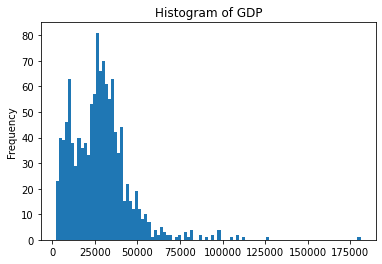

In [4]:
gdf_nuts['gdp'].plot(
    kind='hist', bins=100, title='Histogram of GDP');

# Load Normalized Amenity Features

In [5]:
filepath = "data/europe-amenity-features.csv.gz"

df = pd.read_csv(filepath, index_col='nuts_id')
df.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,car_wash,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre
nuts_id,,,,,,,,,,,,,,,,,,,,,
AL,0.000605,0.0004,0.000323,0.000749,0.000343,0.000018,0.000475,0.00002,0.00063,0.000145,...,0.0001,0.000053,0.000035,0.000005,7.027518e-07,0.000038,0.000001,0.000009,0.000008,0.000013
AL0,0.000605,0.0004,0.000323,0.000749,0.000343,0.000018,0.000475,0.00002,0.00063,0.000145,...,0.0001,0.000053,0.000035,0.000005,7.027518e-07,0.000038,0.000001,0.000009,0.000008,0.000013


# Correlation between Amenities and GDP

In [6]:
from scipy.stats import pearsonr

In [7]:
amenity = 'fast_food'

df_tmp = gdf_nuts.join(df).dropna(subset=[amenity, "gdp"])
pearsonr(df_tmp[amenity], df_tmp['gdp'])

(0.4192140671625608, 1.4648955158350875e-52)

In [8]:
np.corrcoef(df_tmp[amenity], df_tmp['gdp'])

array([[1.        , 0.41921407],
       [0.41921407, 1.        ]])

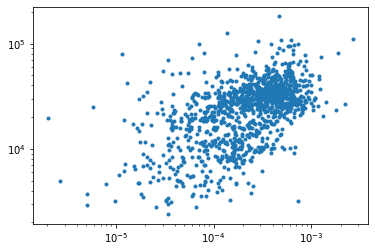

In [9]:
plt.loglog(df_tmp[amenity], df_tmp['gdp'], '.');

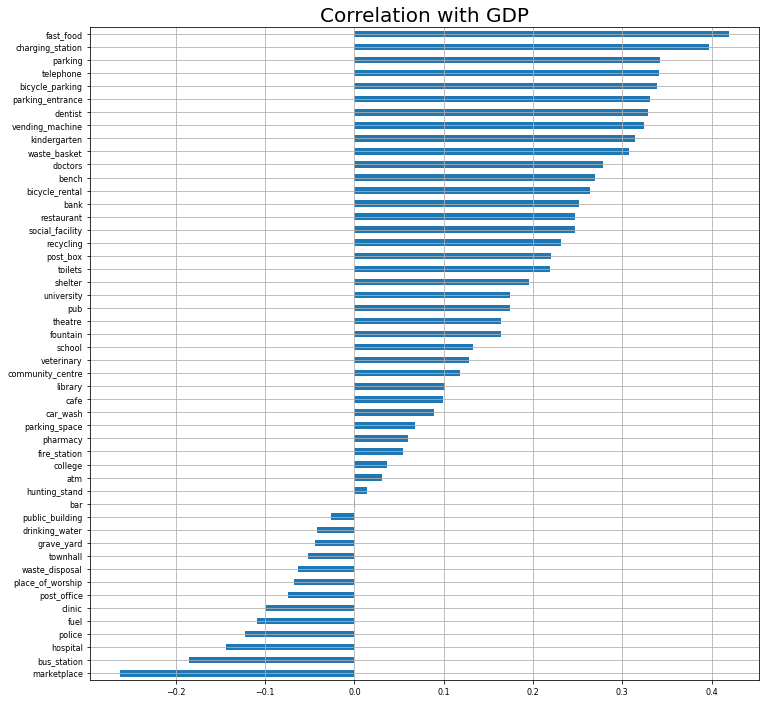

In [10]:
correlations = []
for amenity in df:
    df_tmp = gdf_nuts.join(df).dropna(subset=[amenity, 'gdp'])
    r = pearsonr(df_tmp[amenity], df_tmp['gdp'])[0]
    correlations.append(r)
    
s_corr = pd.Series(
    correlations, 
    index=df.columns)

fig, ax = plt.subplots(figsize=(12, 12))

s_corr.sort_values().plot(
    ax=ax, kind='barh', fontsize=8, grid=True);
ax.set_title("Correlation with GDP", fontsize=20);

# Linear Regression

In [11]:
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_val_score)
from sklearn.decomposition import PCA
from scipy.stats import median_absolute_deviation

In [12]:
df_tmp = df[~df.isna().all(axis=1)].join(gdf_nuts['gdp']).copy()
df_tmp = df_tmp[df_tmp['gdp'].notna()]
df_tmp.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre,gdp
nuts_id,,,,,,,,,,,,,,,,,,,,,
AL011,0.000345,NaN,0.000216,0.000233,0.000570,NaN,0.000406,NaN,0.000345,0.000035,...,0.000017,0.000009,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,3400.0
AL012,0.000275,0.000031,0.000096,0.000196,0.000093,0.000007,0.000519,NaN,0.000107,0.000041,...,0.000007,0.000024,NaN,NaN,0.000003,NaN,NaN,NaN,NaN,4400.0


In [13]:
n = 50
X = df_tmp.iloc[:, 0:n].fillna(0).values
y = df_tmp['gdp'].values

In [14]:
reg = LinearRegression()
reg.fit(X, y)

scores = cross_val_score(
    reg, X, y, 
    scoring='neg_mean_squared_error', 
    cv=LeaveOneOut())

print(f'RMSE: {np.sqrt(-scores.mean()):.2f} ' \
      f'RMSD: {np.sqrt(scores.std()):.2f}')

RMSE: 12746.67 RMSD: 26980.43


In [15]:
nuts_level = 3

EXTENT = [-19.6,32.9,47.7,72.2]  # Europe without colonies
mask = (gdf_nuts['levl_code'] == nuts_level) \
     & gdf_nuts.within(shapely.geometry.box(*EXTENT)) \
     & (~gdf_nuts['population'].isna()) \
     & (gdf_nuts['country'] != 'TR')

y_pred = reg.predict(X)
df_tmp['error'] = np.abs(y_pred - y) / y

gdf_tmp = gdf_nuts[mask].copy()
gdf_tmp = gdf_tmp.join(df_tmp['error'])

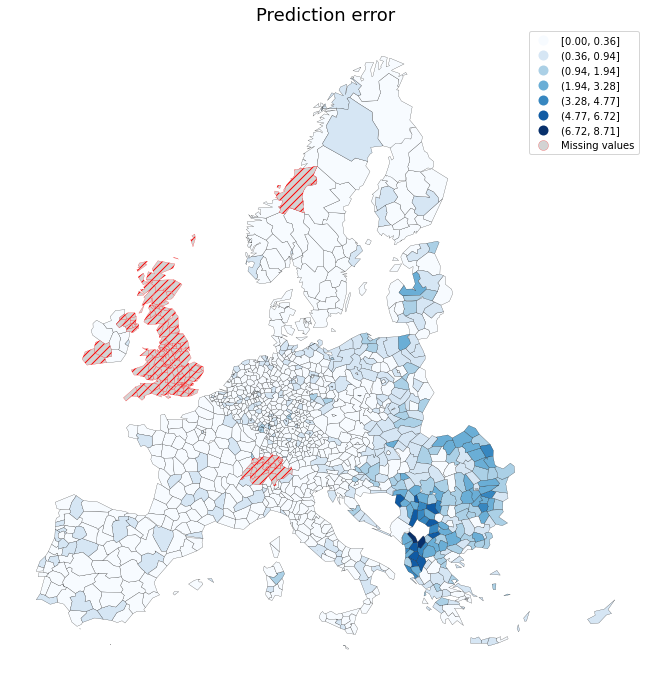

In [16]:
fig, ax = plt.subplots(figsize=(16, 12))

gdf_tmp.to_crs(epsg='3035').plot(
    ax=ax,
    column='error',
    cmap='Blues',
    legend=True,
    linewidth=0.2,
    scheme='natural_breaks',
    k=7,
    edgecolor='k',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    });

ax.set_title("Prediction error", fontsize=18)
ax.set_axis_off();

# Compare Models

In [17]:
df_tmp = df.copy()

In [18]:
df_tmp = df[~df.isna().all(axis=1)].join(
    gdf_nuts[gdf_nuts['country'] == 'DE']['gdp'])
df_tmp = df_tmp[df_tmp['gdp'].notna()]
df_tmp.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre,gdp
nuts_id,,,,,,,,,,,,,,,,,,,,,
DE111,0.004417,0.004983,0.000574,0.001321,0.000494,0.000327,0.000116,0.002670,0.000442,0.000467,...,0.000016,0.000006,0.000008,0.000041,0.000031,0.000308,0.000131,0.000011,0.000080,90900.0
DE112,0.014422,0.006260,0.001102,0.001357,0.000838,0.000257,0.000265,0.001064,0.000303,0.000425,...,0.000025,0.000036,0.000013,0.000120,0.000003,0.000221,0.000036,0.000051,0.000043,66300.0


In [19]:
nuts_level = 3

EXTENT = [-19.6,32.9,47.7,72.2]  # Europe without colonies
mask = (gdf_nuts['levl_code'] == nuts_level) \
     & gdf_nuts.within(shapely.geometry.box(*EXTENT)) \
     & (~gdf_nuts['population'].isna()) \
     & (gdf_nuts['country'] == 'DE')

gdf_tmp = gdf_nuts[mask].copy()

In [20]:
n = 50
X = df_tmp.iloc[:, 0:n].fillna(0).values
y = df_tmp['gdp'].values

In [21]:
%%time
models = [Ridge, RidgeCV, Lasso, LassoCV]

for model in models:
    reg = model()
    reg.fit(X, y)
    
    y_pred = reg.predict(X)
    error_pct = 100 * np.abs(y - y_pred) / y
    
    model_name = model.__name__.lower()
    df_tmp[model_name] = error_pct
    gdf_tmp = gdf_tmp.join(df_tmp[model_name])
    
    scores = cross_val_score(
        reg, X, y, 
        scoring='neg_mean_squared_error', 
        cv=LeaveOneOut())
    
    print(f'{model.__name__:7s} ' \
          f'RMSE: {np.sqrt(-scores.mean()):.2f}, ' \
          f'RMSD: {np.sqrt(scores.std()):.2f}')

Ridge   RMSE: 16751.06, RMSD: 34957.66
RidgeCV RMSE: 16687.81, RMSD: 34991.56
Lasso   RMSE: 15242.75, RMSD: 33747.36
LassoCV RMSE: 14921.53, RMSD: 33964.35
CPU times: user 4min 26s, sys: 15.3 s, total: 4min 41s
Wall time: 1min 18s


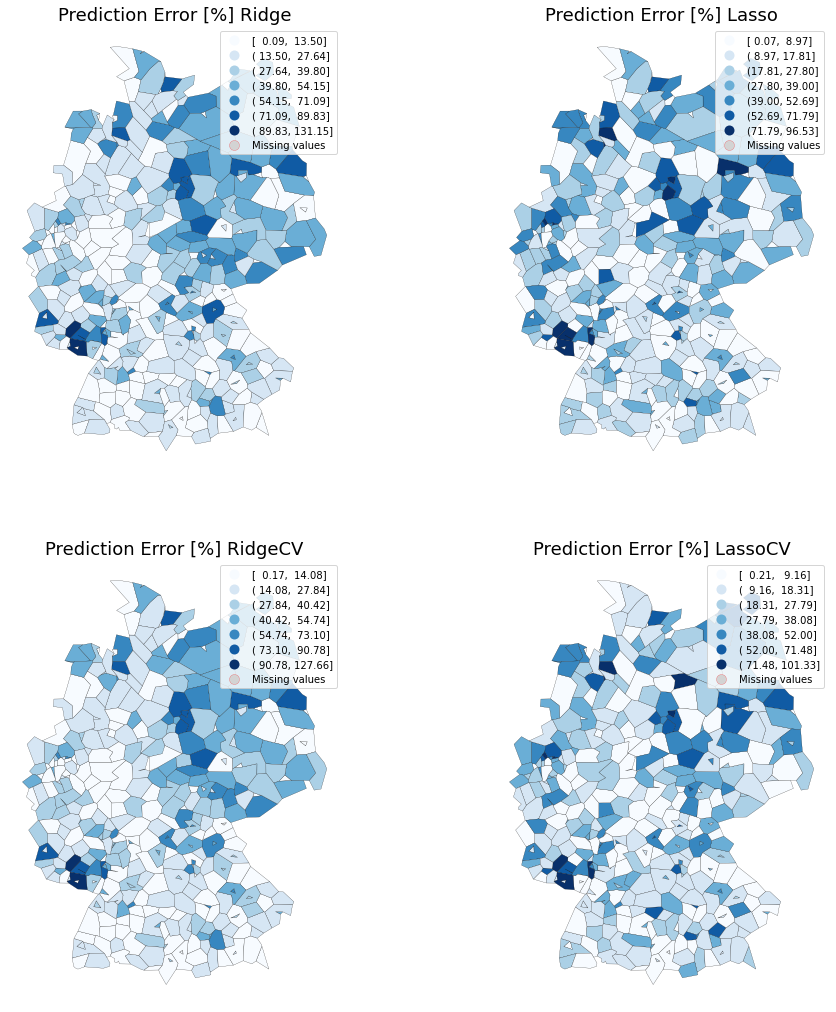

In [22]:
nrows, ncols = 2, 2

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(16, 18))

for idx, model in enumerate(models):
    i = idx % nrows
    j = (idx - i) // nrows
    model_name = model.__name__.lower()
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        gdf_tmp.to_crs(epsg='3035').plot(
            ax=axes[i][j],
            column=model_name,
            cmap='Blues',
            legend=True,
            linewidth=0.2,
            scheme='natural_breaks',
            k=7,
            edgecolor='k',
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"
            });

    axes[i][j].set_title(f"Prediction Error [%] {model.__name__}", fontsize=18)
    axes[i][j].set_axis_off();